<a href="https://colab.research.google.com/github/eridanirojas/563-rojas/blob/main/3DMCSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Sampling Project for MSE 563
# Summary: This project aims to simulate a Markovian-Chain Metroplis Monte Carlo simulation in 3 dimensions, using the Lennard Jones potential
# to calculate pairwise potentials. The goal is to see the overall performance of this model, including equilibration times, accuracy, runtimes,
# and output ensemble.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import math
import time
import copy

# 1. Lennard Jonesium , sigma = 1.0, epsilon = 1.0

In [5]:
# Initialize system
class System():
  def __init__(self,N,L,T):
    self.V = L**3
    self.L = L
    self.N = N
    self.T = T
    self.particles = self.fill_system(N, L, r_min=1.0)  # Ensure spacing

  def fill_system(self, N, L, r_min=1.0):
    # Reduce chances of two particles overlapping, so rare this is enough to cover it
    particles = []
    while len(particles) < N:
      new_particle = L * np.random.rand(3)
      too_close = any(np.linalg.norm(new_particle - p) < r_min for p in particles)
      if not too_close:
        particles.append(new_particle)  # Add if spacing is fine
    return np.array(particles)

  def compute_energy(self, ideal_gas = False, epsilon = 1.0, sigma = 1.0, r_cut = 2.5):
    # To calculate energy of a system
    energy_sum = 0.0
    pairs = 0
    virial_sum = 0.0
    if ideal_gas is True: # If system behaves as an ideal gas, there can be no interactions
      pressure = (self.N * self.T / self.V)
      return energy_sum, pairs, pressure # energy, pairs, and pressure
    for i in range(self.N - 1):
        for j in range(i + 1, self.N):
            e, v = self.LJ_potential(self.particles[i], self.particles[j], epsilon, sigma, r_cut)
            energy_sum += e
            virial_sum += v
            if not np.isclose(e, 0.0):
                pairs += 1
    pressure = (self.N * self.T / self.V) + (virial_sum / (3 * self.V))
    return energy_sum, pairs, pressure # energy, pairs, and pressure

  def distance(self, particle1, particle2):
    # Distance between two particles considering PBCs

    # Displacement vector
    delta = particle2 - particle1

    # Shifting to be between -L/2 and L/2
    delta -= np.round(delta / self.L) * self.L

    # Distance
    r = np.linalg.norm(delta)

    return r

  def LJ_potential(self, particle1, particle2, epsilon, sigma, r_cut):
    # LJ potential and virial theorem

    # Getting distance with PBCs in mind
    r = self.distance(particle1, particle2)
    if r > r_cut:
      return 0.0, 0.0

    # Handling overlaps
    if np.isclose(r, 0.0):
      print("too close")
      return np.inf, np.inf

    # Compute LJ potential
    sr6 = (sigma / r) ** 6
    sr12 = sr6 * sr6

    # Lennard-Jones Force
    F_LJ = 24.0 * epsilon * (2 * sr12 - sr6) / r

    # Virial summation contribution: r * F
    v = r * F_LJ

    return 4.0 * epsilon * (sr12 - sr6), v

  def plot(self, particles, L, title = "Current configuration"):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(particles[:,0], particles[:,1], particles[:,2], c='blue', marker='o')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_zlim(0, L)
    plt.title(title)
    plt.show()

# 2. Simulation implementation

In [6]:
# Monte Carlo Simulation, with Markov-Chain implementation and with delta as a step size, from Frenkel and Smit

def simulation(system, steps, T=1.0, delta = 1.0, epsilon = 1.0, sigma = 1.0, r_cut = 2.5, ideal_gas = False):
    # Making a copy to not disturb initial configuration
    sim_system = copy.deepcopy(system)

    # Calculate initial energy and initial virial sum
    energy, pairs, pressure = sim_system.compute_energy(ideal_gas, epsilon, sigma, r_cut)

    # Pressure list
    pressures = [pressure]
    # Energy list
    energies = [energy]

    # Configuration list
    configs = [copy.deepcopy(sim_system.particles)]

    # Initialize accepted and rejected tally
    accepted = 0
    rejected = 0

    for step in range(steps):
        # Pick a random particle
        i = np.random.randint(sim_system.N)

        # Store initial position
        initial_pos = sim_system.particles[i].copy()

        # Compute initial energy of system
        E_initial, _, P_initial = sim_system.compute_energy(ideal_gas, epsilon, sigma, r_cut)

        # Propose a move using step size factor delta
        displacement = (np.random.rand(3) - 0.5) * delta
        sim_system.particles[i] += displacement

        # PBCs, if applicable to displacement
        sim_system.particles[i] %= sim_system.L

        # Compute final energy and pressure
        E_final, _, P_final = sim_system.compute_energy(ideal_gas, epsilon, sigma, r_cut)
        dE = E_final - E_initial

        # Metropolis criteria
        if np.random.rand() < np.exp(-dE/T):
            accepted += 1
            energy = E_final # Accept the move
            pressure = P_final
        else:
            sim_system.particles[i] = initial_pos # Reject the move
            rejected += 1
            energy = E_initial
            pressure = P_initial

        energies.append(energy) # Energy history
        configs.append(copy.deepcopy(sim_system.particles)) # Configuration history
        pressures.append(pressure) # Pressure history

    return energies, accepted, rejected, configs, pressures

High density system

In [7]:
N = 29
L = 6
T = 0.05
V = L**3

In [8]:
system = System(N,L,T)

## Extreme State Simulation and results, T = 0.05 and high density N/V = .8. Too small is when N/V > 0.8, as there will be lots of repulsion and it'll be much harder to approach equilibrium. Too big is when N/V < 0.2, where V is simply too much space to cover for N, unless given enough timesteps and a large enough stepsize, which could cause issues with ergodicity. The sweet spot is around 0.5 - 0.8 it seems.


In [9]:
energies, accepted, rejected, configs, pressures = simulation(system, 10000, T = T, delta = 1.0, epsilon = 1.0, sigma = 1.0, r_cut = 2.5, ideal_gas = False)

In [10]:
acceptance_rate = accepted/(accepted + rejected)

# Low acceptance rate is expected

In [11]:
print(acceptance_rate)

0.0263


In [12]:
energies[0]

-21.169280545306385

In [13]:
energies[-1]

-78.5421676739689

# My attempt to derive an EOS of a system, only applicable to non-ideal gasses. Z = PV/NT.

Text(0.5, 1.0, 'Compressibility factor over time')

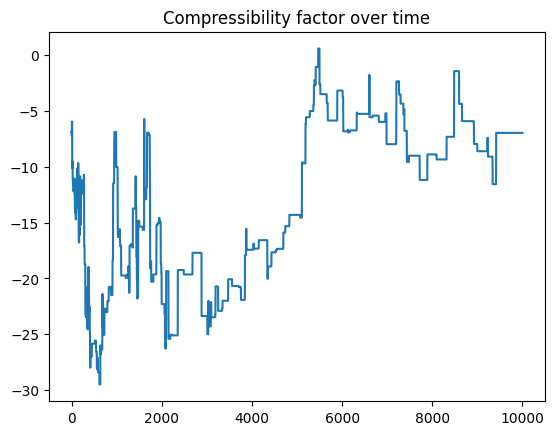

In [14]:
Z_values = [(P * V) / (N * T) for P in pressures] # Relationship between pressure, volume, and temperature of system, equation of state?
plt.plot(Z_values)
plt.title("Compressibility factor over time")

# Energy steadily decreasing with little fluctuation, expected with low T. It takes over 10,000 steps to equilibrate with extreme density and low T.

Text(0.5, 1.0, 'Energy over time for high density low temperature')

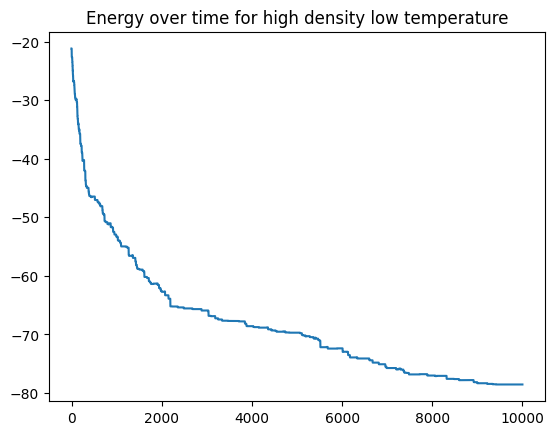

In [15]:
plt.plot(energies)
plt.title("Energy over time for high density low temperature")

# Pressure of each step, calculated via Virial Theorem within System class. As system approaches equilibrium, pressure increases.

Text(0.5, 1.0, 'Pressure over time')

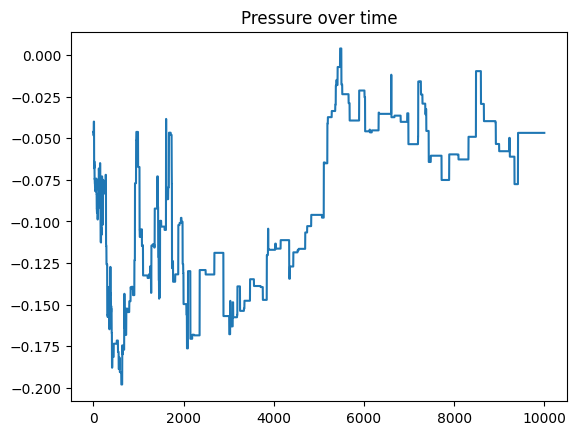

In [16]:
plt.plot(pressures)
plt.title("Pressure over time")

## Initial vs Final Configuration, packing is happening!

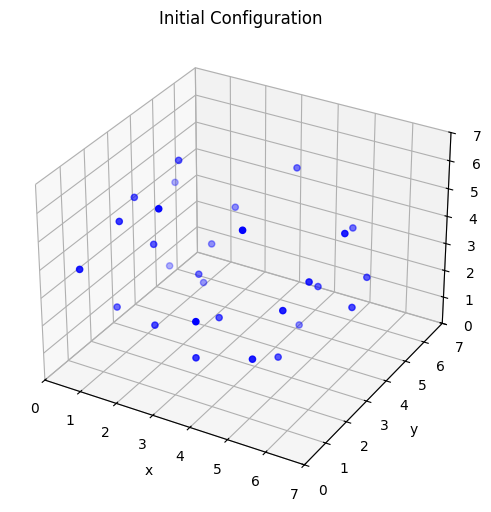

In [17]:
system.plot(configs[0], 7, title = "Initial Configuration")

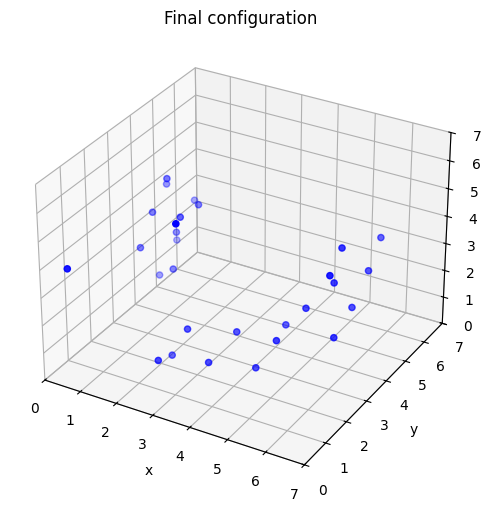

In [18]:
system.plot(configs[-1], 7, title = "Final configuration")

## Immediately, a limitation is made known that I did not know how to chase down: high Cv for non-ideal systems.

In [19]:
mean_energy = np.mean(energies)
mean_energy_squared = np.mean(np.array(energies)**2)

In [20]:
Cv = (mean_energy_squared - mean_energy**2) / (T**2)

In [21]:
print(Cv)

43022.45566637138


## Contrast with ideal systems, lower timesteps because there will be no equilibrating.

In [22]:
ideal = System(13,4,0.05)
i_energies, i_accepted, i_rejected, i_configs, i_pressures = simulation(ideal, 1000, T = T, delta = 1.0, epsilon = 1.0, sigma = 1.0, r_cut = 2.5, ideal_gas = True)

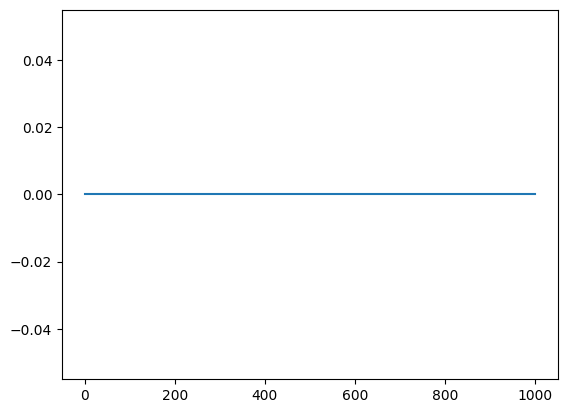

In [23]:
plt.plot(i_energies)

## Pressure is calculated via ideal gas law in System class.

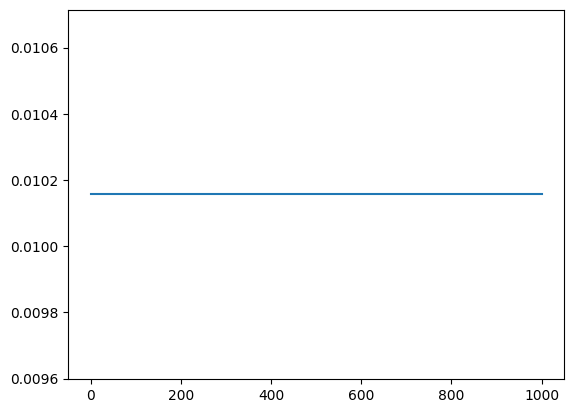

In [24]:
plt.plot(i_pressures)

In [25]:
i_pressures[0]

0.01015625

## Since every move is accepted in an ideal gas system, particles can just go where they please at random essentially.

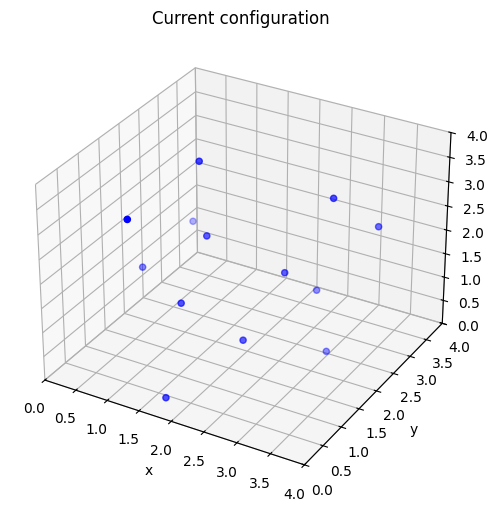

In [26]:
ideal.plot(i_configs[0], 4)

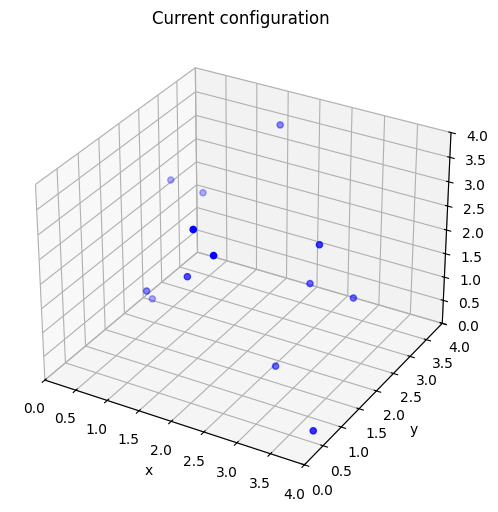

In [27]:
ideal.plot(i_configs[-1], 4)

## Specific heat for ideal gas is easy to calculate, and makes sense in this case.

In [28]:
Cv_ideal = 1.5*13

In [29]:
print(Cv_ideal)

19.5


# Summary: My simulation can reliably approach equilibrium as well as prevent overlaps when initializing original configuration. It can provide insight on equilibrium times and behaviors at equilibrium for any given sigma and epsilon. Some limitations are tied to the fact that I do not have a tail correction implemented as I am unsure whether or not it is necessary or even useful, as well as my specific heat being incredibly high for non-ideal systems. While working through 1-4, I realized that I needed to implement a way to prevent overlaps in the initialization to keep the plot from looking incredibly messy, and my biggest revelation was that I could calculate a virial sum whilst calculating the LJ potential using the same r between two particles.